## VSP Processing - from Raw  Data to Separated Up and Down Waves  

This notebook works through the pre-processing and processing required to 
separate the upgoing and downgoing waves of a Vertical Seismic Profile.  

<img src="nb_images\process_4.png" width="600" height="600" align="left" />  
<br clear="left"/>   
<br>
<br>  

The data was generated using the __VSProwess__ Finite Difference modelling module.  
The model is elastic, anisotropic, and 2D. And fictional!

The notebook follows these basic steps:

1. Read VSP from a SEG-Y file
2. Update geometry and calculate velocities
3. Gain Recovery  
4. Normalize on the downgoing amplitudes  
5. Median Filter Up/Down Separation
6. Median Filter Noise Reduction  
7. Write outputs to SEG-Y files

At the end of the notebook there are some Frequency Analysis and Filtering Examples.


### Imports and Packages  

Import the necessary packages to make the notebook run!

Your python installation should include numpy, scipy, matplotlib, Tabulate,  
and segyio. And Jupyter obviously!

After downloading the code from github repo, make sure the  
following folders exist in the path of the notebook:  
1. iovsp  
2. procvsp  
3. plotvsp

In [13]:
### The following 3 imports expand the useable area of the notebook
### Adjust percents to make bigger or smaller
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
display(HTML("<style>.output_result { max-width:80% !important; }</style>"))
#display(HTML("<style>.prompt { display:none !important; }</style>"))

### the following import should let outputs scroll if they are too wide
from IPython.display import display, HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

# important geophysical imports
# I use several methods to load packages as examples

from iovsp.segyin import readsegyio3
from iovsp.segyout import write_segyio

from plotvsp.seisplots import wiggle_plot, four_plots
from procvsp.geometry import importascii, geovel

# Best method is the one below, you always know where functions are 
# coming from
import procvsp.spec as specvsp
import procvsp.sigproc as sgp
import procvsp.utils as utilvsp
#%matplotlib inline

## 1. Read the VSP SEG-Y file  

 - uses segyio data loading package
 - source and receiver locations are assumed to be in SEG-Y trace headers
 - user needs to supply basic geometry parameters
      - seismic replacement velocity
      - surface seismic datum elevation
      - drill floor elevation
      - source elevation  

The sample rate read from the file needs to be QC'ed!!!  

In addition to reading the segy file, some basic geometry 'headers' are created,  
and saved in an array.

<img src="nb_images\geometry_a.png" width="400" height="400" align="left" />  
<br clear="left"/>   
<br>
<br>  

$D_{source} = Elev_{SRD} – Elev_{source}$  

$D_{SRD} = (Elev_{SRD} – Elev_{KB}) + D_{KB}$



In [14]:
#################### get the ZVSP SEGY filename ############################
    
#    filename = ('C:\\Users\\acampbell45\\Documents\\Python_Scripts'
#        '\\Synthetic_data\\data\\zvsp_z_fd_mod6_12p5ft_grid_delayed.sgy')

filename = ('data\\zvsp_z_fd_mod6_12p5ft_grid_delayed.sgy')
    
################### input desired geometry parameters ######################

RepVel= 5000     # replacement velocity
SRD_ASL = 0    # Seismic Reference Datum SRD elevation above sea level
DF_ASL = 0    # drill floor elevation ASL
SrcElev = -10   # source elevation ASL

###################### run basic segy loading functions #################### 
    
file_head = 'y'         # print binary and text header to screen    
pr_thead = 'n'          # print a table of trace headers    
data, numsamp, samprate, fs, theader =  readsegyio3(filename, file_head, 
                                            DF_ASL, SrcElev, SRD_ASL, pr_thead)

	JobID                   0          
	LineNumber              0          
	ReelNumber              0          
	Traces                  1          
	AuxTraces               0          
	Interval                1000       
	IntervalOriginal        0          
	Samples                 3050       
	SamplesOriginal         0          
	Format                  5          
	EnsembleFold            0          
	SortingCode             0          
	VerticalSum             0          
	SweepFrequencyStart     0          
	SweepFrequencyEnd       0          
	SweepLength             0          
	Sweep                   0          
	SweepChannel            0          
	SweepTaperStart         0          
	SweepTaperEnd           0          
	Taper                   0          
	CorrelatedTraces        0          
	BinaryGainRecovery      0          
	AmplitudeRecovery       0          
	MeasurementSystem       2          
	ImpulseSignalPolarity   0          
	VibratoryPolarity       0          
	

## 2. Velocity Calculations  

The geometry parameters are used to calculate vertical velocities.  
The velocities are saved along with geometry in the header array for future use.  

The Replacement Velocity (RepVel) for land surveys is usually supplied by the client.  
RepVel is used to correct for elevation changes between the source and the seismic datum (SRD).  

Receiver depths should be corrected to vertical, and referenced to both the SRD,  
and the source elevation.

<img src="nb_images\geometry_1.png" width="400" height="400" align="left" />  
<br clear="left"/>   
<br>
<br>  

- Calculate interval velocities. Shallowest velocity is calculated separately and tacked on to  
  the header array  
- Optionally print to screen a version which is rounded and truncated  

1. $\theta = arctan(O_{SR}/D_{SRVert})$  


2. $T_{source} = D_{source}/RepVel$  


3. $T_{vertical} = cos(\theta) * (T_{observed})$  


4. $T_{SRD} = T_{vertical} + T_{source}$  


5. $Average Velocity = D_{SRD} / T_{SRD}$  


6. $Interval Velocity = ΔD_{SRD} / ΔT_{SRD}$


In [15]:
############ geometry corrections and velocity calculations 
# Average and interval columns added to header array

table = 'n'     # print a time-depth-velocity listing to screen y or n    
vel_headers = geovel( theader, RepVel, table)
    


̲G̲e̲o̲v̲e̲l̲ ̲S̲t̲a̲t̲s̲ ̲:
 Theader shape (320, 15) Vheader shape: (320, 17)
 TVD_SRD shape : (320,)  IntVel shape : (320,)
 TVDSrc 2 vals   [ 90. 140.] 
 TVDSRD 2 vals  [100. 150.] 
 TTVert 2 vals   [10.902 17.332]


### Chose the desired trace range to process

In [16]:
############ trim data and header arrays by receiver  

first_rcv =20
last_rcv = 220    
data_edit, theader_edit = utilvsp.depthlimit(data,vel_headers, first_rcv, last_rcv)


̲D̲e̲p̲t̲h̲l̲i̲m̲i̲t̲ ̲S̲t̲a̲t̲s̲ ̲:
 data shape :  (320, 3050)  data dtype :  float32
 headers shape : (320, 17)
 first : 19  last :  219
 headers new shape : (200, 17)
 data new shape :  (200, 3050)


### Make a wiggle plot of raw data  

pol : n for normal or tape polarity, r to flip polarity  
spacing : 'z' is spread traces by receiver depth, else traces are evenly spaced  
skiplabel : plot every nth recever depth label at bottom of plot  
fs : sample rate in hertz, may be set elsewhere in notebook    
norm : plot trace normalization 'n' or 'y'  
scal : multiply every sample by this number to heat or cool plot  
info_wig : print diagnostic information to terminal  
timframe: 'owt' is one-way time, 'twt' is two-way time, 'flat' is flattened using a  
reference time, usually the downgoing direct arrival pick  

A scalar (__scal__) usually needs to be applied to make reasonable deflections,  
dependent on data amplitudes and plot spacing

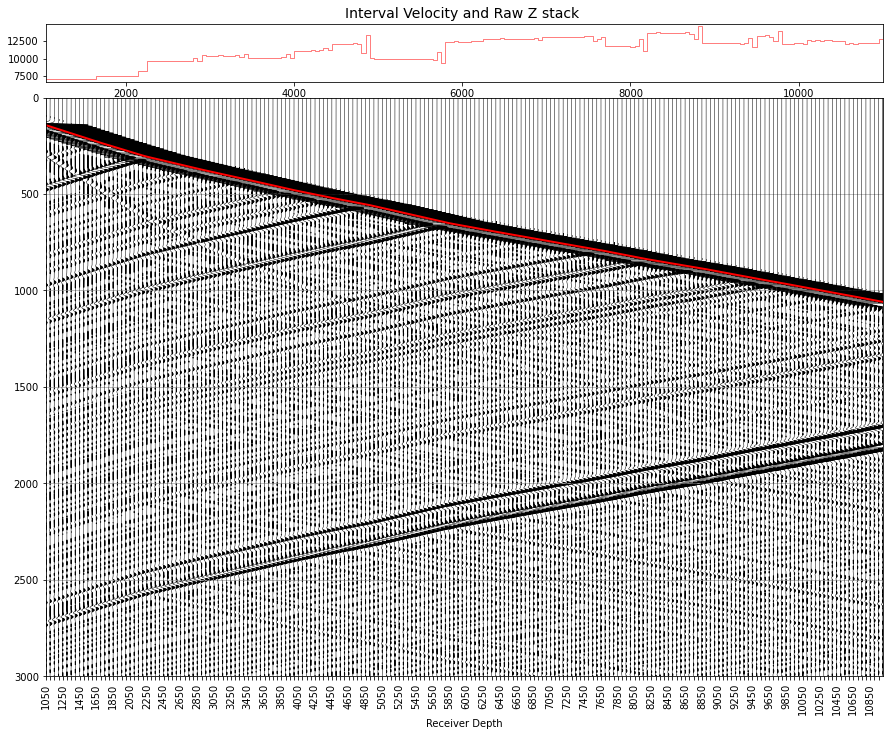


̲W̲i̲g̲g̲l̲e̲ ̲P̲l̲o̲t̲ ̲G̲l̲o̲b̲a̲l̲ ̲I̲n̲f̲o̲r̲m̲a̲t̲i̲o̲n̲ ̲:
 Number of traces in plot : 200  Number of samples per trace : 3050
 VSPdata type : float32
 sample rate (hz) 1000.0  min max plot time 0.0 3049.0
 thead shape : (200, 17)
 Min TVDSRD - pad 1049.0  Pad : 1
 Max TVDSRD + pad 11001.0  Pad : 1
 min max intvel : 7082.152974504239 14577.25947521847


In [17]:
############ first plot of wiggles and velocities 

plot_params = {"pol":'n', 
               "Tmax":3000, "Tmin":0, 
                "first_rcv":first_rcv, 
                "spacing":'z', 
                "skiplabel":4, 
                "fs":fs, 
                "norm":'y',
                "scal":500,#100000000000, 
                "title_top":'Raw Z stack ',
                "info_wig":'y',
                "timframe":'owt'} 
wiggle_plot(theader_edit,data_edit, **plot_params)        

## 3. Geometric spreading correction  
Apply a T**n correction  
Applied from first sample of trace to correct for spreading loss


̲T̲A̲R̲ ̲P̲a̲r̲a̲m̲e̲t̲e̲r̲s̲ ̲:
 VSP.shape : (200, 3050)  gainfunc.shape : (1, 3050)


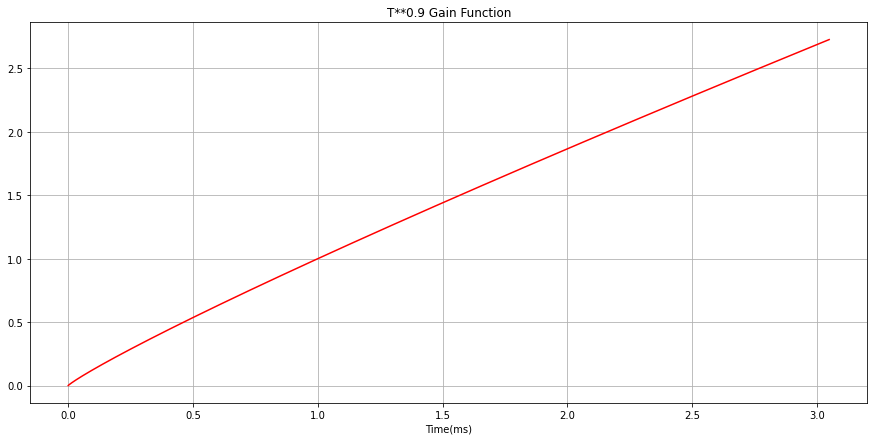

In [18]:
######### apply geometric spreading compensation

texp = .9 # usually ranges from 1 to 2
tarVSP = sgp.tar(data_edit,theader_edit,fs,texp )

### Make a wiggle plot of gain corrected data  

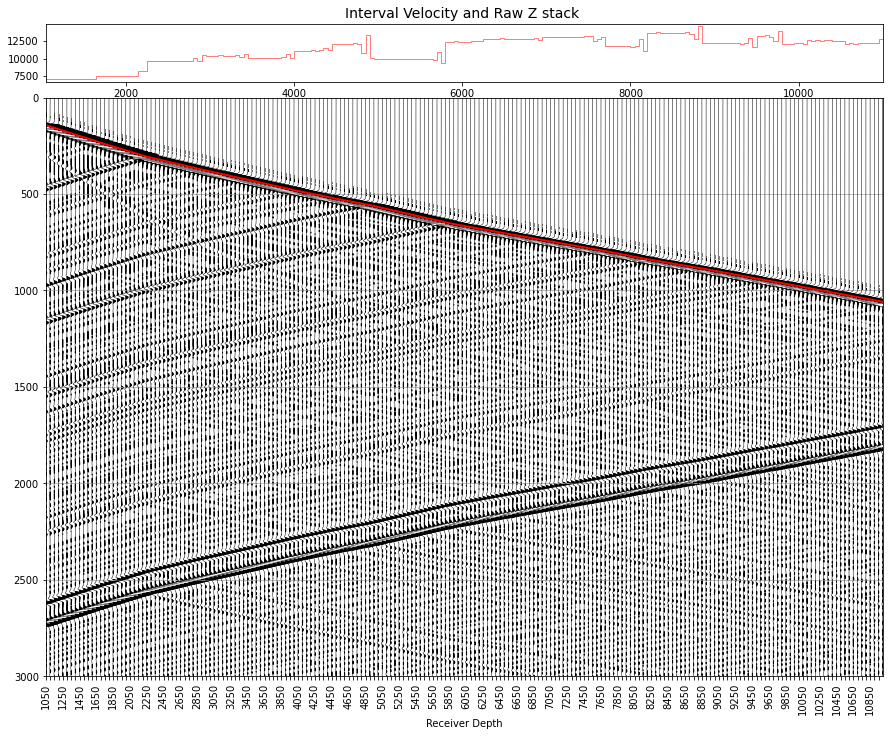


̲W̲i̲g̲g̲l̲e̲ ̲P̲l̲o̲t̲ ̲G̲l̲o̲b̲a̲l̲ ̲I̲n̲f̲o̲r̲m̲a̲t̲i̲o̲n̲ ̲:
 Number of traces in plot : 200  Number of samples per trace : 3050
 VSPdata type : float64
 sample rate (hz) 1000.0  min max plot time 0.0 3049.0
 thead shape : (200, 17)
 Min TVDSRD - pad 1049.0  Pad : 1
 Max TVDSRD + pad 11001.0  Pad : 1
 min max intvel : 7082.152974504239 14577.25947521847


In [19]:
############ plot of gain corrected VSP 

plot_params = {"pol":'n', 
               "Tmax":3000, "Tmin":0, 
                "first_rcv":first_rcv, 
                "spacing":'z', 
                "skiplabel":4, 
                "fs":fs, 
                "norm":'n',
                "scal":100000000000, 
                "title_top":'Raw Z stack ',
                "info_wig":'y',
                "timframe":'owt'} 
wiggle_plot(theader_edit,tarVSP, **plot_params)        

## 4. Trace normalize data file  
 Remove tool coupling changes, transmission effects and uncorrected gain effects  
 on downgoing by normalizing the downgoing amplitudes  
 - normalize by trace (receiver), dividing by the max amplitude of that trace.  
 - in future, a window around the direct arrival will be considered 
 
This is an __optional__ step, but done routinely at some shops.Shown here as a demonstration  
only



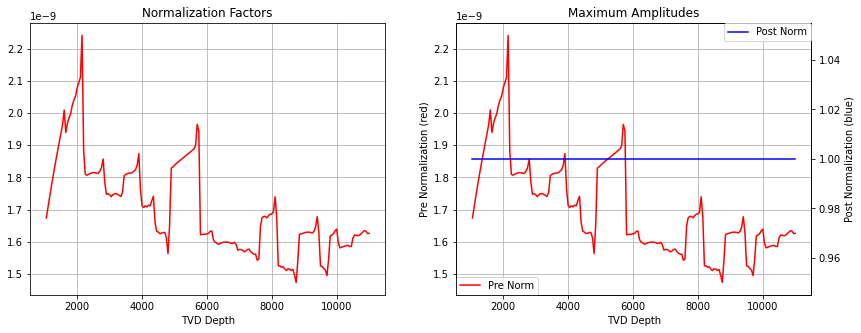

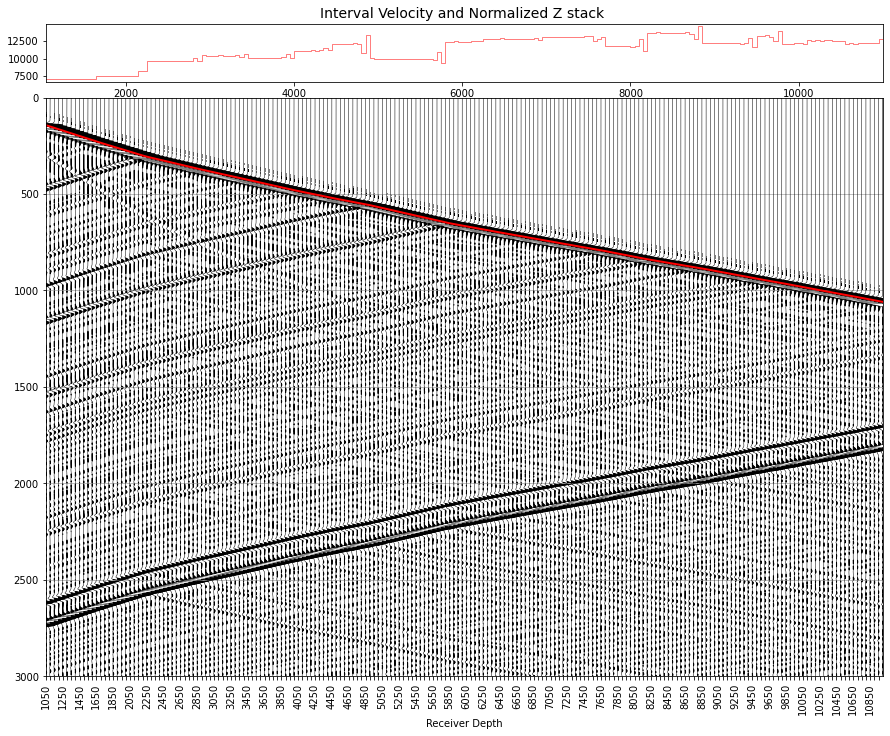

In [20]:
############  apply trace normalization if requested 

Data_norm = 'y'         # normalize data, n for gather norm, y for trace nrm
DScalar = 1             # usually 1, may be removed in future    
normed_edit = sgp.normalize(tarVSP, Data_norm, theader_edit, DScalar)

plot_params = {"pol":'n', 
                "Tmax":3000, "Tmin":0, 
                 "first_rcv":first_rcv, 
                 "spacing":'z', 
                 "skiplabel":4, 
                 "fs":fs, 
                "norm":'n',
                "scal":200, 
                "title_top":'Normalized Z stack ',
                "info_wig":'n',
                "timframe":'owt'} 
wiggle_plot(theader_edit,normed_edit, **plot_params)                     

## 5a. Median Filter -  Preparation  

### Static shift to flatten (align) traces at the direct arrival 

Shifts by a time header value.  
Arbitrary time can be used to flatten (align) data at.  

Ultimate goal is to flatten the downgoing arrival to allow a median filter  
to enhance the downgoing data


̲S̲h̲i̲f̲t̲i̲n̲g̲ ̲P̲a̲r̲a̲m̲e̲t̲e̲r̲s̲ ̲:
 fs : 1000.0 
  atime : 250 
  first arr2 shape : (200, 3050)


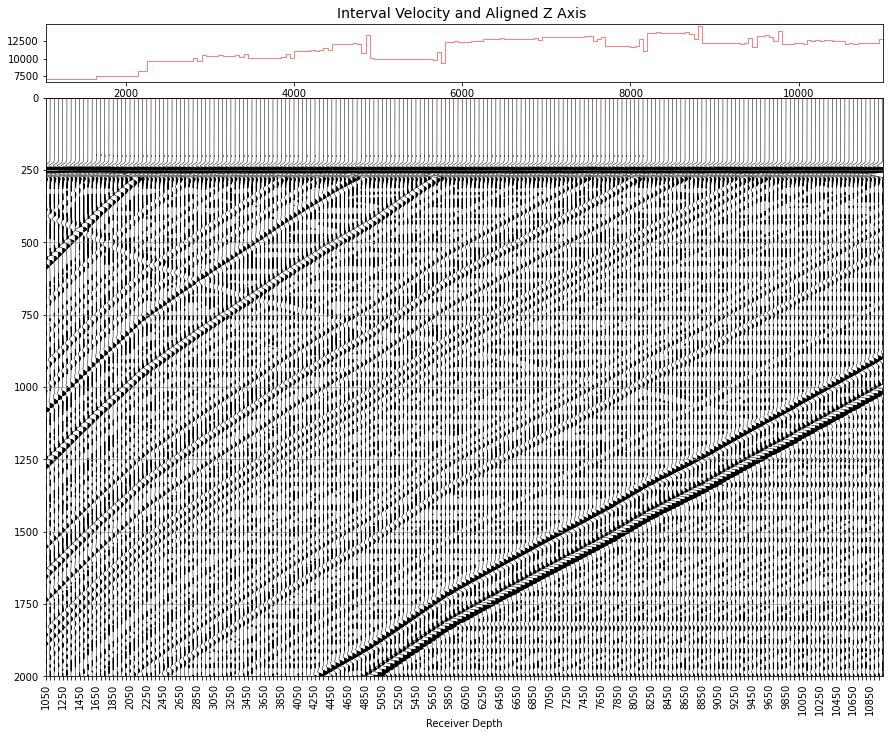

In [21]:
########### align downgoing by shifting traces ################################################
 
updown = 'down' # down to align downgoing at aligntime, up to shift to TWT, 
                    # unalign to shift from aligned at aligntime to 1WT    
aligntime = 250 # align downgoing at 500ms    
alignedVSP, theader_sh = utilvsp.shift(normed_edit, theader_edit, updown, aligntime, 
                                   fs)    
plot_params = {"pol":'n', 
                "Tmax":2000, "Tmin":0, 
                "first_rcv":first_rcv, 
                "spacing":'z', 
                "skiplabel":4, 
                "fs":fs, 
                "norm":'n',
                "scal":200, 
                "title_top":'Aligned Z Axis ',
                "info_wig":'n',
                "timframe":'flat'} 
wiggle_plot(theader_edit,alignedVSP, **plot_params)               



## 5b Median Filter to enhance the aligned downgoing waves  
Run the median filter across the traces, at equal sample times.  
 - Repeat for every time step  
 - Median will reject anomolous amplitudes and preserve the continuous amplitudes
  - The reflections are anomalous in a carefully chosen trace window  
  
The trace window is chosen:
 - to avoid smoothing (too long) or
 - ineffective noise rejection( too short)  
 
Usually subtract the enhanced downgoing from the raw data to get the upgoing


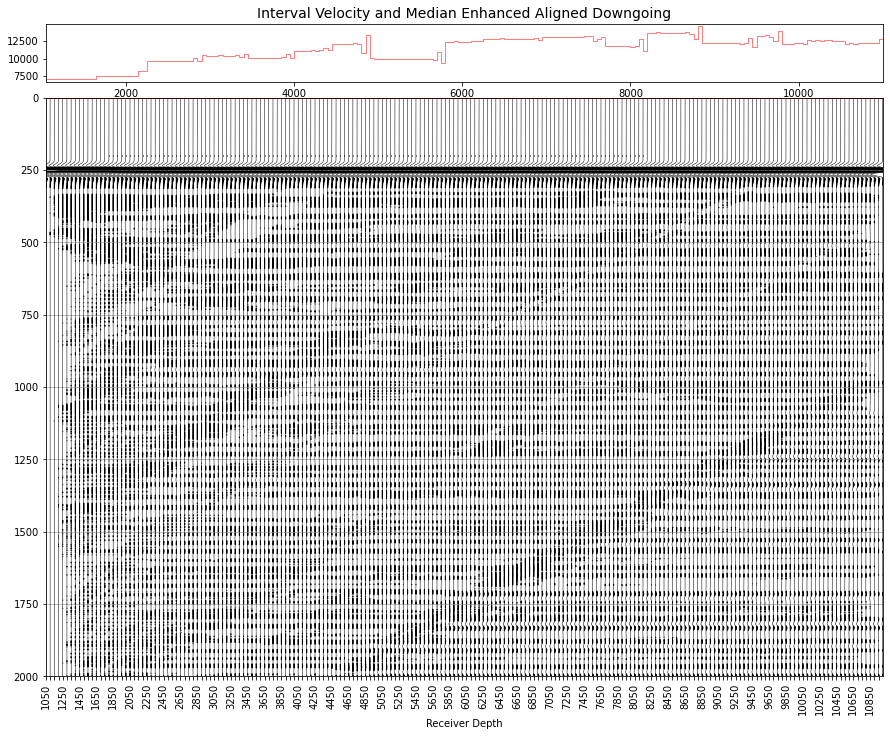

In [22]:
########### median filter to enhance the downgoing ###############################################
    
levels = 15
aligndown_scipy = sgp.medfilt(alignedVSP, levels) # pad with zeros
    
plot_params = {"pol":'n', 
                "Tmax":2000, "Tmin":0, 
                "first_rcv":first_rcv, 
                "spacing":'z', 
                "skiplabel":4, 
                "fs":fs, 
                "norm":'n',
                "scal":200, 
                "title_top":'Median Enhanced Aligned Downgoing',
                "info_wig":'n',
                "timframe":'flat'} 
wiggle_plot(theader_edit,aligndown_scipy, **plot_params)               

## 5c Difference the downgoing and raw data  
Raw data has had normalization applied  
Subtracting the downgoing from the raw data should leave upgoing waves  
 - other waves not aligned with the down P could also be left in the difference data
   - tube waves, shear waves are examples

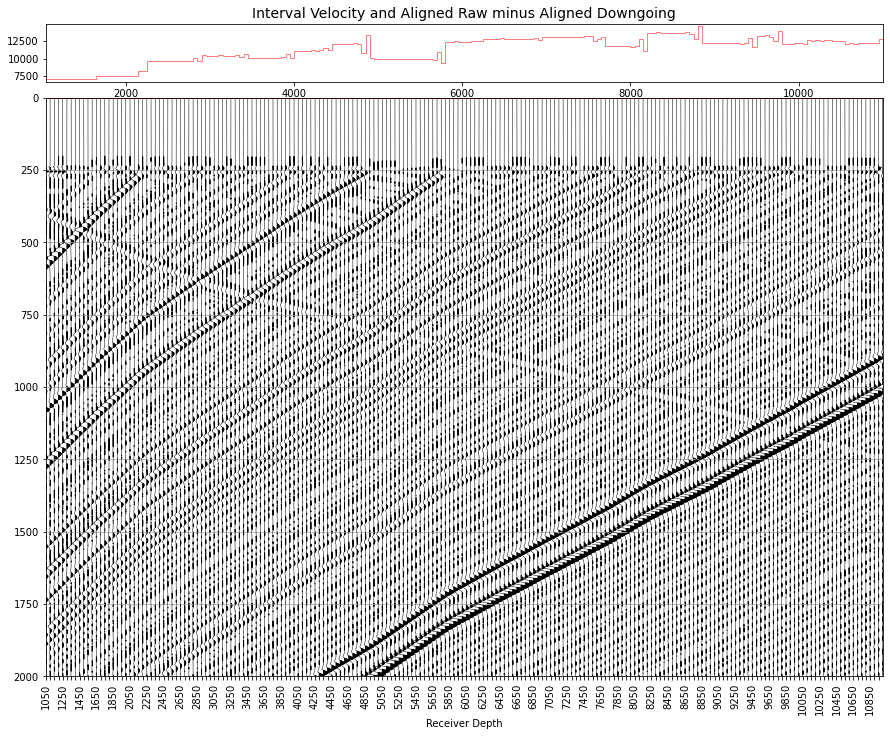

In [23]:
###### subtract the aligned downgoing from the aligned and normalized raw data

residual = utilvsp.diff(alignedVSP, aligndown_scipy)

plot_params = {"pol":'n',
                "Tmax":2000, "Tmin":0, 
                "first_rcv":first_rcv, 
                "spacing":'z', 
                "skiplabel":4, 
                "fs":fs, 
                "norm":'n',
                "scal":200, 
                "title_top":'Aligned Raw minus Aligned Downgoing',
                "info_wig":'n',
                "timframe":'flat'} 
wiggle_plot(theader_edit,residual, **plot_params)        

## 5d Static shift back to observed time 


̲S̲h̲i̲f̲t̲i̲n̲g̲ ̲P̲a̲r̲a̲m̲e̲t̲e̲r̲s̲ ̲:
 fs : 1000.0 
  atime : 250 
  first arr2 shape : (200, 3300)


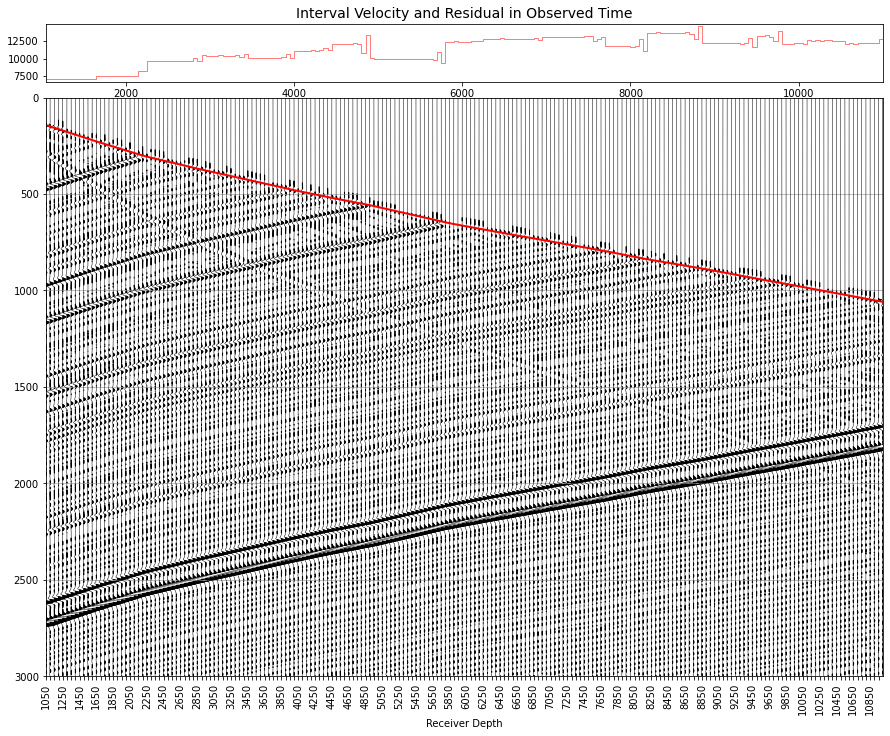

In [24]:
##### shift the data back to observed time frame

updown = 'unalign'

upwave1WT, theader_sh = utilvsp.shift(residual, theader_edit, updown, aligntime,fs)

plot_params = {"pol":'n',
                "Tmax":3000, "Tmin":0, 
                "first_rcv":first_rcv, 
                "spacing":'z', 
                "skiplabel":4, 
                "fs":fs, 
                "norm":'n',
                "scal":200, 
                "title_top":'Residual in Observed Time',
                "info_wig":'n',
                "timframe":'owt'} 
wiggle_plot(theader_edit,upwave1WT, **plot_params)   

## 6a Median filter noise reduction  
### Static shift to two-way time  

Zero-offset VSP geometry makes it trivial to convert from observed time to two-way time
 - shift each trace by it's measured arrival time is all that is needed  
 
Now the upgoing waves are flattened (aligned)  

A median filter run parallel to the reflections should reduce any random noise


̲S̲h̲i̲f̲t̲i̲n̲g̲ ̲P̲a̲r̲a̲m̲e̲t̲e̲r̲s̲ ̲:
 fs : 1000.0 
  atime : 250 
  first arr2 shape : (200, 3300)
 pad twt :  2242  arr shape : (200, 5542)
 second arr2 shape : (200, 5542)


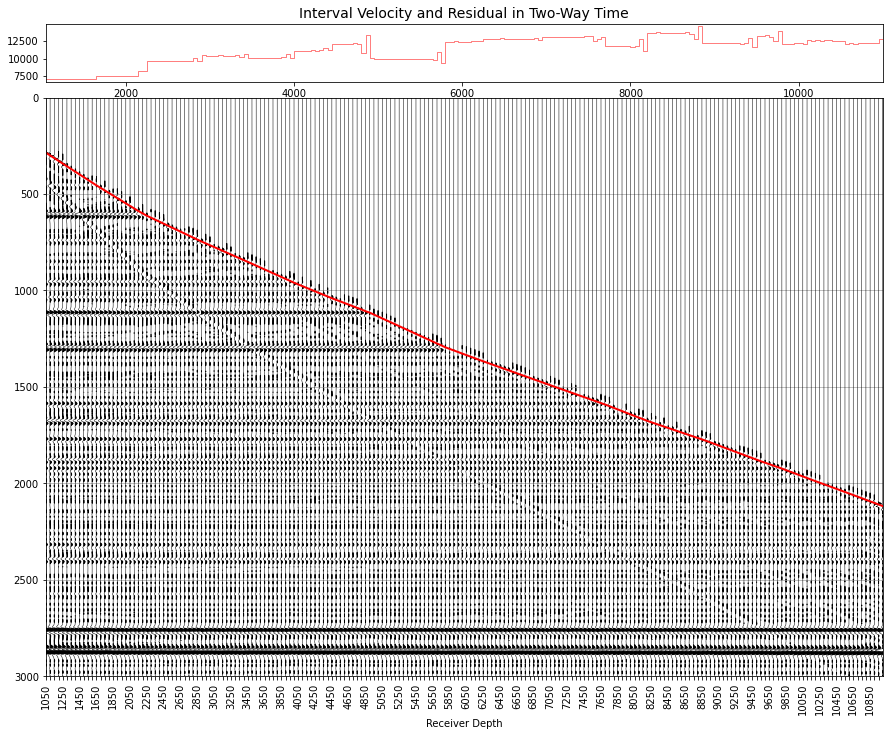

In [25]:
##### now shift from observed time frame to two-way time
updown = 'up'     

upwave2WT, theader_2wt = utilvsp.shift(upwave1WT, theader_edit, updown, aligntime, 
                                  fs)    
plot_params = {"pol":'n',
                "Tmax":3000, "Tmin":0, 
                "first_rcv":first_rcv, 
                "spacing":'z', 
                "skiplabel":4, 
                "fs":fs, 
                "norm":'n',
                "scal":200, 
                "title_top":'Residual in Two-Way Time',
                "info_wig":'n',
                "timframe":'twt'} 
wiggle_plot(theader_edit,upwave2WT, **plot_params)   

## 6b Median Filter to enhance the aligned upgoing waves  
Run the median filter across the traces, at equal sample times.  
 - Repeat for every time step  
 - Median will reject anomolous amplitudes and preserve the continuous amplitudes
  - noise spikes, shear waves, tube waves are anomalous in a carefully chosen trace window  
  
The trace window is chosen:
 - to avoid smoothing (too long) or
 - ineffective noise rejection( too short) 
A mute prior to the arrival time (two-way) may be required due to edge effects


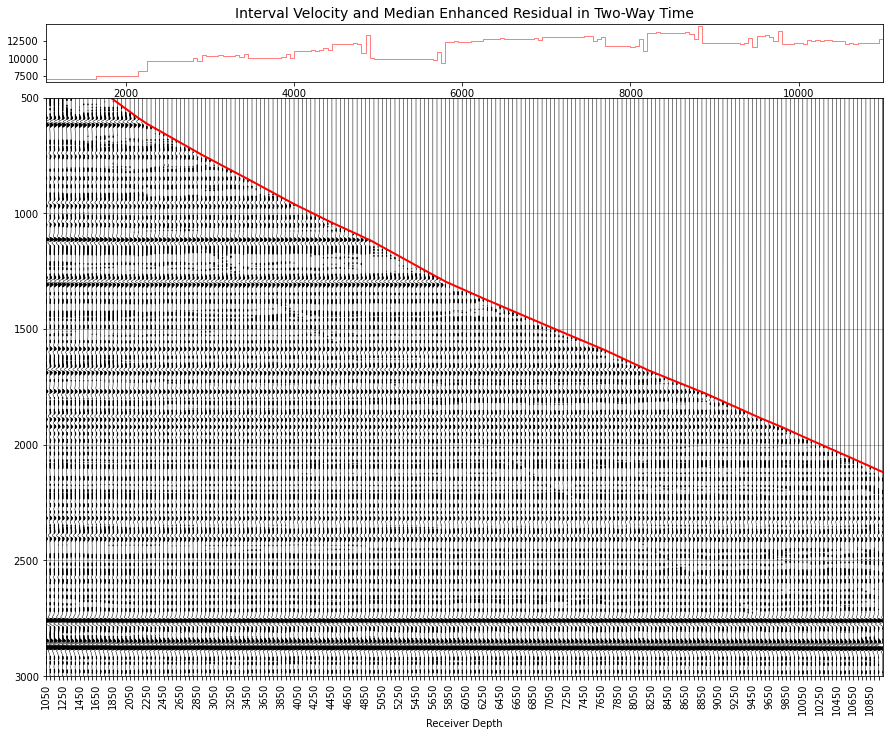

In [26]:
##### apply a median fiter across the traces to enhance the upgoing waves
# 1.Used to reduce noise. Maybe applied before or after decon
# 2. Apply a mute to reduce filter noise at direct arrival

levels = 5    
medianup2WT = sgp.medfilt(upwave2WT, levels)

tframe = 'twt' # owt or twt    
mute_medianup2WT = utilvsp.mute(medianup2WT,fs, theader_edit, tframe)

plot_params = {"pol":'n', 
                "Tmax":3000, "Tmin":500, 
                "first_rcv":first_rcv, 
                "spacing":'z', 
                "skiplabel":4, 
                "fs":fs, 
                "norm":'n',
                "scal":200, 
                "title_top":'Median Enhanced Residual in Two-Way Time',
                "info_wig":'n',
                "timframe":'twt'} 
wiggle_plot(theader_edit,mute_medianup2WT, **plot_params)               

## 7. Write outputs to SEG-Y  
Uses segyio package to write out SEG-Y files  
The output directories have to exist
 - using the full path may be necessary

In [29]:
###########  output segy 

'''
outfilename = ('C:\\Users\\acampbell45\\Documents\\Python_Scripts'
                  '\\Synthetic_data\\data\\residual_2wt.sgy')
    
outfilename2 = ('C:\\Users\\acampbell45\\Documents\\Python_Scripts'
              '\\Synthetic_data\\data\\down_flat.sgy')
'''    
outfilename = ('data\\residual_2wt.sgy')    
outfilename2 = ('data\\down_flat.sgy')    
  
write_segyio(mute_medianup2WT, theader_2wt, fs, outfilename)    
write_segyio(aligndown_scipy, theader_edit, fs, outfilename2)



̲W̲r̲i̲t̲e̲ ̲S̲e̲g̲y̲i̲o̲ ̲S̲t̲a̲t̲s̲ ̲:
Data shape [0] : 200 Data shape [1] : 5542
Trace header shape (200, 17)
time header : [[ 2.00000000e+01  1.05000000e+03  1.05000000e+03  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+01
   1.42790000e+02  1.05000000e+03  1.04000000e+03 -1.00000000e+01
   1.00000000e+00  1.10000000e+01  0.00000000e+00  2.85580000e+02
   7.10227273e+03]
 [ 2.10000000e+01  1.10000000e+03  1.10000000e+03  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+01
   1.49840000e+02  1.10000000e+03  1.09000000e+03 -1.00000000e+01
   1.00000000e+00  1.10000000e+01  0.00000000e+00  2.99680000e+02
   7.09219858e+03]]
MD shape : (200,)  MD dtype : int32
 MD [1:10] : [10500 11000 11500 12000 12500 13000 13500 14000 14500 15000]  TVD[0:10] : [10500 11000 11500 12000 12500 13000 13500 14000 14500 15000]
 spec.tracecount : 200

̲W̲r̲i̲t̲e̲ ̲S̲e̲g̲y̲i̲o̲ ̲S̲t̲a̲t̲s̲ ̲:
Data shape [0] : 200 Data shape [1] : 3300
Trace heade

## Single trace frequency analysis  
A Tukey window is applied to the input trace, prior to FFT  


̲F̲r̲A̲n̲ ̲P̲a̲r̲a̲m̲e̲t̲e̲r̲s̲ ̲:
fs : 1000.0


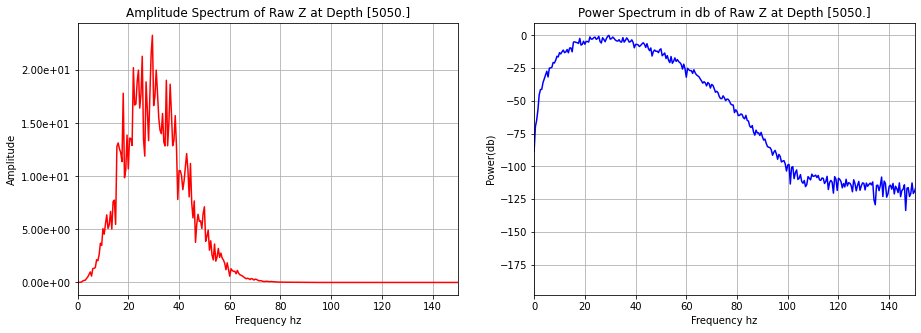

In [30]:
#########  FRequency ANalysis  
trace = 80
time_win = 'y' # window trace prior to fft
time_range = [0, 2000]
freq_range = [0, 150]    
title_fran = 'Raw Z'    
specvsp.spec_1d(normed_edit, time_range, freq_range, theader_edit, trace, fs, 
         time_win, title_fran)

## Example of Applying a Band-Pass( Butterworth) Filter  
 - Make 2 simple QC plots of frequency and impulse response
 - Plot the filtered VSP

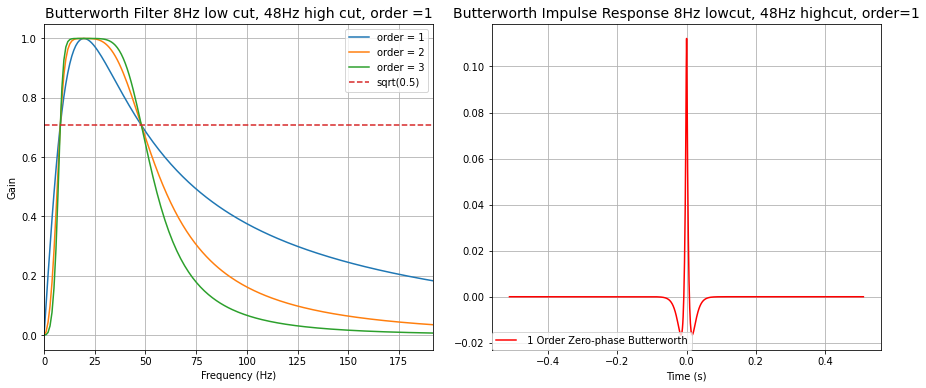

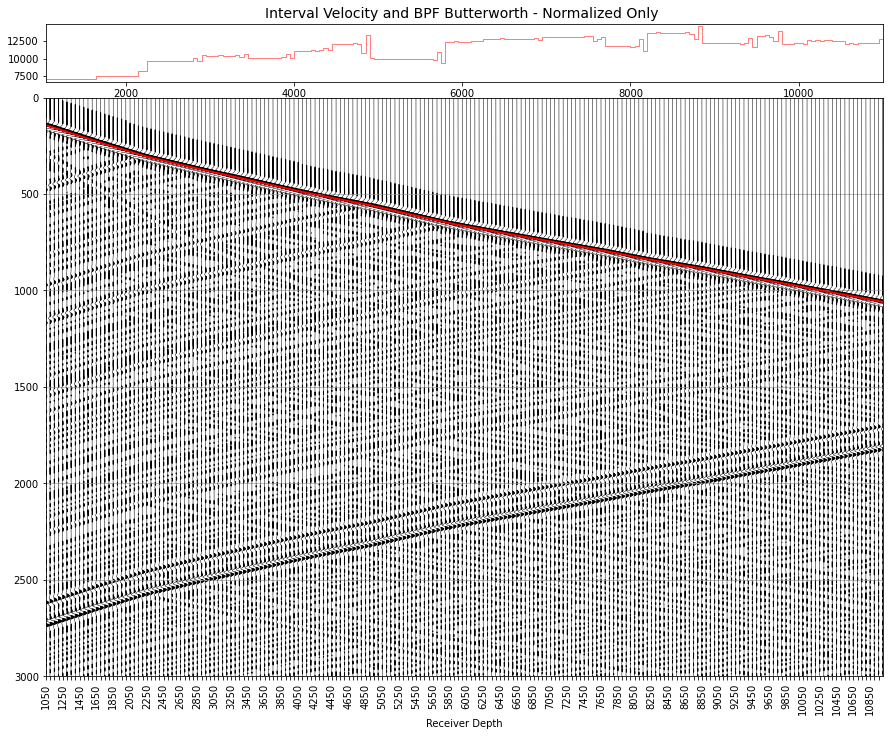

In [31]:
################### Apply a band-pass filter 
# Uses a Butterworth filter    
# Sample rate and desired cutoff frequencies (in Hz).

lowcut =8
highcut = 48    
qcplot = 'y'
order  = 1     # order gets doubled by implementation of filter, be careful    
numfsamp = 1024   # for wavelet QC plot, must be even      
buttfilt = specvsp.bandpass_filter(normed_edit, lowcut, highcut, fs, order, 
                                      numfsamp, qcplot)

plot_params = {"pol":'n', 
                "Tmax":3000, "Tmin":0, 
                "first_rcv":first_rcv, 
                "spacing":'z', 
                "skiplabel":4, 
                "fs":fs, 
                "norm":'n',
                "scal":100, 
                "title_top":'BPF Butterworth - Normalized Only ',
                "info_wig":'n',
                "timframe":'owt'} 
wiggle_plot(theader_edit,buttfilt, **plot_params)                   

## Alternate Processing Flow Plot - Four Boxes  
A nice compact plot showing all processing steps  
 - plots D and E are the same, for comparison purposes

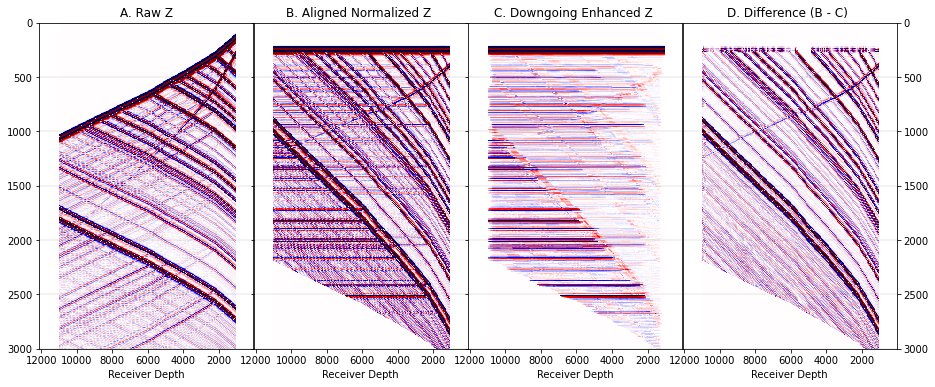

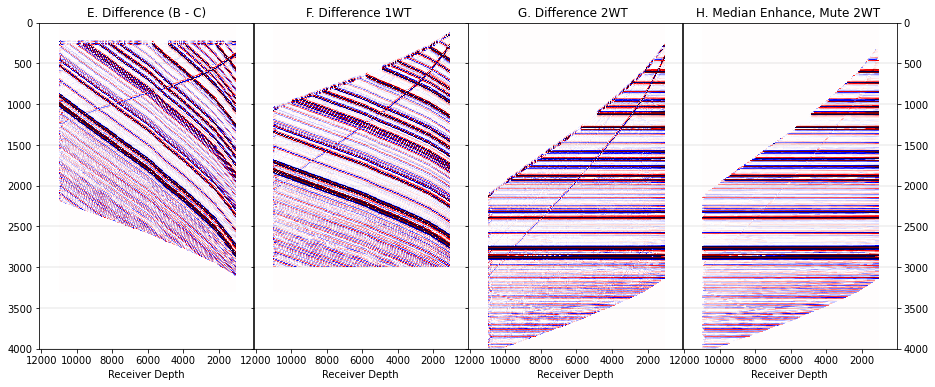

In [32]:
########## make thumbnail processing plots 
    
plot4_params = {    
    'ss_title1' : "A. Raw Z",    
    'ss_title2' : "B. Aligned Normalized Z",    
    'ss_title3' : "C. Downgoing Enhanced Z",    
    'ss_title4' : "D. Difference (B - C)",    
    'savePNG' : 'y',    
    'png_name' : 'pre_decon',        
    'scalar' : [100,20,20,8],             # scaling to plot 1,2,3,4 amplitudes    
    'time_range' : [0, 3000],    
    'depth_range' : [12100, 50],
    'info_gray4' : 'n'}
four_plots(data_edit, alignedVSP, aligndown_scipy, residual, fs, 
               theader_edit, **plot4_params)
plot4_params = {   
    'ss_title1' : "E. Difference (B - C)",    
    'ss_title2' : "F. Difference 1WT",    
    'ss_title3' : "G. Difference 2WT",    
    'ss_title4' : "H. Median Enhance, Mute 2WT",
    'savePNG' : 'y',        
    'png_name' : 'pre_decon_enh',    
    'scalar' : [10,10,10,10,4],            # scaling to plot 1,2,3,4, amplitudes    
    'time_range' : [0, 4000],    
    'depth_range' : [12100, 50],
    'info_gray4' : 'n'}
four_plots(residual, upwave1WT, upwave2WT, mute_medianup2WT, fs, 
               theader_edit, **plot4_params)
    